# Fine-Tuned YOLO Model with Oversampling and Normalization

## Main Features

The modeling process focused on the safety of construction workers and the presence of PPE gear. The following classes were used to train the model:

- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- Machinery
- Vehicle

## Model Choice

The **YOLOv9** model was selected due to its efficient object detection capabilities.

### Key Features Considered:

- **Convolutional Neural Network (CNN) Backbone**: Utilizes CNN for feature extraction, essential for detecting and classifying objects in images.

- **CSPDarknet Architecture**: The model leverages CSPDarknet, which helps in focusing on the crucial details in the image, optimizing both speed and accuracy in feature extraction.

- **Anchor-Free Detection**: YOLOv9 uses an anchor-free approach, meaning it doesn’t rely on predefined areas (anchors) for object detection. Instead, it dynamically adapts to objects of varying sizes and shapes, enhancing detection accuracy across different object scales.


### Package to install

In [ ]:
# !pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

### Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import torch
import random
import yaml
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO
from google.colab import drive

### Pre setup for drive access and configuration for YOLO model



### Fine-Tuning Applied:

- **Epochs**: 50  
  - Reduced the number of epochs to prevent overfitting, which could occur due to the oversampling applied.

- **Batch Size**: 16  
  - The number of training examples used in one iteration, set to 16 for better generalization.

- **Learning Rate**: 1e-3  
  - Defines the speed at which the model learns from the data.

- **Learning Rate Factor**: 0.01  
  - Controls the gradual reduction of the learning rate during training, allowing for faster initial learning and finer adjustments later.

- **Weight Decay**: 5e-4  
  - Penalizes large weights to prevent overfitting, ensuring the model generalizes well to new data.

- **Patience**: 20  
  - Specifies the number of epochs to wait without improvement in validation, helping to prevent overfitting by stopping training when further progress stalls.

- **Image Size (Imgsz)**: 640  
  - Consistent image size of 640x640 pixels was maintained for uniformity in training.

- **Optimizer**: ‘Auto’  
  - The optimizer adjusts the weights of the model during training to minimize the loss function, with automatic selection based on the model’s configuration.


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths in Google Drive
drive_base_path = '/content/drive/MyDrive/Capstone'

# Directory paths
TRAIN_IMAGE_PATH = os.path.join(drive_base_path, 'data', 'images', 'train')
TEST_IMAGE_PATH = os.path.join(drive_base_path, 'data', 'images', 'test')
VALID_IMAGE_PATH = os.path.join(drive_base_path, 'data', 'images', 'valid')

TRAIN_LABEL_PATH = os.path.join(drive_base_path, 'data', 'labels', 'train')
VALID_LABEL_PATH = os.path.join(drive_base_path, 'data', 'labels', 'valid')
TEST_LABEL_PATH = os.path.join(drive_base_path, 'data', 'labels', 'test')

OUTPUT_DIR = os.path.join(drive_base_path, 'model')

class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 50 # updated
    BATCH_SIZE = 16
    BASE_MODEL = 'yolov9e'
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto'
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.1 #updated
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Oversampling
multiple runs were required with changes to the unwanted class parameters and specific classes to achieve more generalized oversampling results.


In [ ]:
import os
import glob
import shutil

def oversample_specific_classes(image_path, label_path, specific_classes, additional_count=1):
    # Initialize class counts
    class_counts = {cls: 0 for cls in CFG.CLASSES}

    # Set of unwanted classes (Person and machinery)
    unwanted_classes = {'Person', 'Safety Cone', 'machinery'}

    # Count instances of each class and filter labels containing only specific classes
    valid_label_files = []
    for label_file in glob.glob(os.path.join(label_path, '*.txt')):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            classes_in_file = set(int(line.split()[0]) for line in lines)
            # Convert class IDs to class names
            classes_in_file_names = {CFG.CLASSES[class_id] for class_id in classes_in_file}
            # Check if the label file contains only specific classes and no unwanted classes
            if classes_in_file_names.issubset(set(specific_classes)) and not classes_in_file_names.intersection(unwanted_classes):
                valid_label_files.append(label_file)
                for class_id in classes_in_file:
                    class_counts[CFG.CLASSES[class_id]] += 1

    # Identify classes that need oversampling
    low_count_classes = [cls for cls in specific_classes if class_counts[cls] < 500]

    print(f"Classes to be oversampled: {low_count_classes}")

    for label_file in valid_label_files:
        with open(label_file, 'r') as f:
            lines = f.readlines()

        for line in lines:
            class_id = int(line.split()[0])
            if CFG.CLASSES[class_id] in low_count_classes:
                # Duplicate the image and label file
                base_name = os.path.basename(label_file).replace('.txt', '')
                img_file = os.path.join(image_path, base_name + '.jpg')

                for i in range(additional_count):
                    new_img_file = os.path.join(image_path, f"{base_name}_aug_{i}.jpg")
                    new_label_file = os.path.join(label_path, f"{base_name}_aug_{i}.txt")

                    shutil.copy(img_file, new_img_file)
                    shutil.copy(label_file, new_label_file)

    print("Oversampling complete.")

# Define the specific classes you want to oversample
specific_classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
                    'NO-Safety Vest', 'Safety Vest', 'vehicle']

# Apply oversampling to the training dataset
oversample_specific_classes(TRAIN_IMAGE_PATH, TRAIN_LABEL_PATH, specific_classes)



Classes to be oversampled: ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Safety Vest', 'vehicle']
Oversampling complete.


## Oversampling results checking

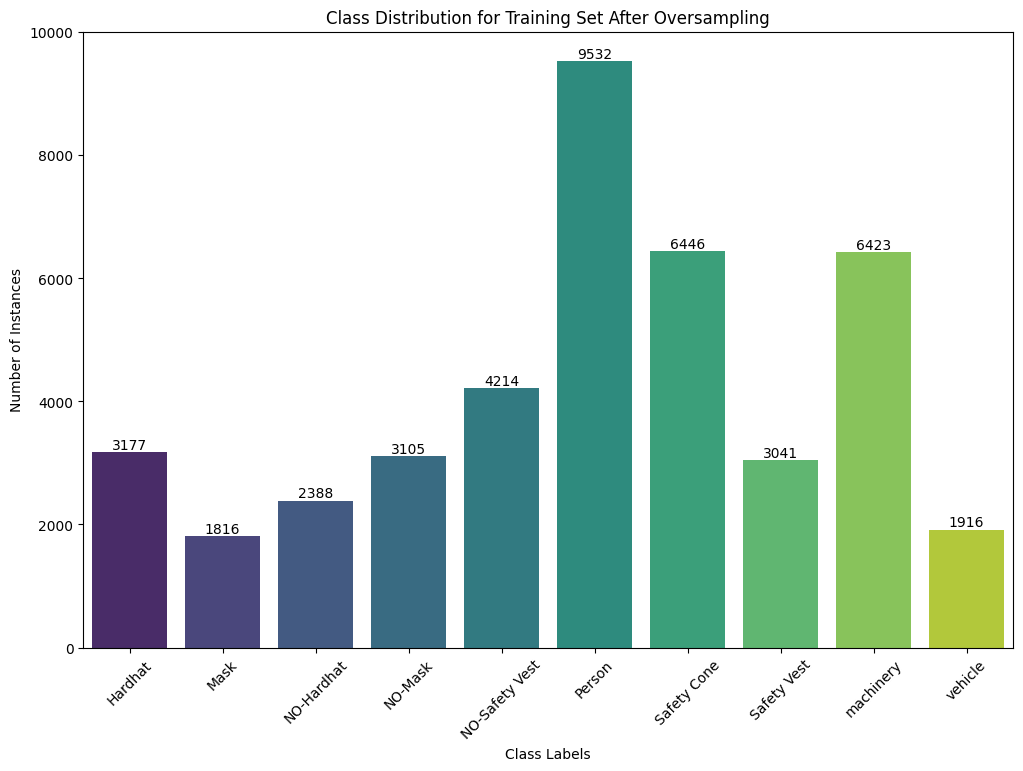

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class labels
class_labels = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest',
                'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

# Path to the training labels directory after oversampling
train_label_dir = TRAIN_LABEL_PATH

# Initialize a dictionary to count each class
class_counts = {label: 0 for label in class_labels}

# Iterate through the training label directory
for label_file in os.listdir(train_label_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_label_dir, label_file), 'r') as f:
            for line in f:
                class_idx = int(line.split()[0])
                class_counts[class_labels[class_idx]] += 1

# Plot the class distribution for the training set
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')

# Add text annotations on the bars
for i in range(len(class_counts)):
    ax.text(i, list(class_counts.values())[i], str(list(class_counts.values())[i]), ha='center', va='bottom')

plt.title('Class Distribution for Training Set After Oversampling')
plt.xlabel('Class Labels')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

- **Instance Ratio:** 
  - The overall ratio between the ‘Person’ class and other classes did not change significantly, as most images had a person labeled.

- **Increase in Instances:**
  - Significant improvements were observed in the number of instances for the classes ‘Mask,’ ‘No-Safety Vest,’ ‘Safety Cone,’ ‘Machinery,’ and ‘Vehicle,’ with increases of up to over 1200 instances for some classes.

- **Safety Cone Class:**
  - The drastic increase in the ‘Safety Cone’ class was unavoidable due to many images containing safety cones, leading to a higher instance count.

### Creating yaml file for YOLO model to access

In [ ]:
def create_yaml_file():
    dict_file = {
        'train': TRAIN_IMAGE_PATH,
        'val': VALID_IMAGE_PATH,
        'test': TEST_IMAGE_PATH,
        'nc': CFG.NUM_CLASSES,
        'names': CFG.CLASSES
    }
    yaml_path = os.path.join(OUTPUT_DIR, 'data.yaml')
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    with open(yaml_path, 'w+') as file:
        yaml.dump(dict_file, file)
    return yaml_path

In [ ]:
### read yaml file created
def read_yaml_file(file_path = OUTPUT_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /content/drive/MyDrive/Capstone/data/images/test
train: /content/drive/MyDrive/Capstone/data/images/train
val: /content/drive/MyDrive/Capstone/data/images/valid



### Checking Image Sizes

In [ ]:
mode_paths = {
    'train': TRAIN_IMAGE_PATH,
    'valid': VALID_IMAGE_PATH,
    'test': TEST_IMAGE_PATH,
}

for mode, path in mode_paths.items():
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(path, '*')):
        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)




### Normalisation Process

Streaming output truncated to the last 5000 lines.
Saved normalized image to /content/drive/MyDrive/Capstone/data/normalized_images/train/youtube-474_jpg.rf.a69f31210940425bb2099ce9f6683645.jpg
Processing image: /content/drive/MyDrive/Capstone/data/images/train/youtube-504_jpg.rf.241ea52c86257e2116da083c77deb845.jpg
Saved normalized image to /content/drive/MyDrive/Capstone/data/normalized_images/train/youtube-504_jpg.rf.241ea52c86257e2116da083c77deb845.jpg
Processing image: /content/drive/MyDrive/Capstone/data/images/train/youtube-435_jpg.rf.cbe965d635b486b4ad5d720d81660470.jpg
Saved normalized image to /content/drive/MyDrive/Capstone/data/normalized_images/train/youtube-435_jpg.rf.cbe965d635b486b4ad5d720d81660470.jpg
Processing image: /content/drive/MyDrive/Capstone/data/images/train/youtube-699_jpg.rf.ced94dd4765a8ff9fe60e7648179fb6d.jpg
Saved normalized image to /content/drive/MyDrive/Capstone/data/normalized_images/train/youtube-699_jpg.rf.ced94dd4765a8ff9fe60e7648179fb6d.jpg
Proce

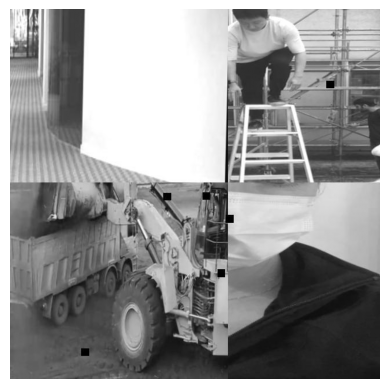

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(image_path):
    try:
        with Image.open(image_path) as img:
            img_array = np.array(img)
            normalized_image_array = img_array / 255.0  # Normalize to [0,1]
            return normalized_image_array, img_array
    except Exception as e:
        print(f"Error processing image at {image_path}: {e}")
        return None, None

def save_normalized_image(normalized_array, original_image_path, save_dir):
    save_path = os.path.join(save_dir, os.path.basename(original_image_path))
    normalized_img = Image.fromarray((normalized_array * 255).astype(np.uint8))  # Convert back to uint8
    normalized_img.save(save_path)
    print(f"Saved normalized image to {save_path}")

def display_image(normalized_array):
    plt.imshow(normalized_array)
    plt.axis('off')
    plt.show()

# Directory paths
train_image_path = TRAIN_IMAGE_PATH
test_image_path = TEST_IMAGE_PATH
valid_image_path = VALID_IMAGE_PATH

# Save directories
normalized_train_dir = os.path.join(drive_base_path, 'data', 'normalized_images', 'train')
normalized_test_dir = os.path.join(drive_base_path, 'data', 'normalized_images', 'test')
normalized_valid_dir = os.path.join(drive_base_path, 'data', 'normalized_images', 'valid')

os.makedirs(normalized_train_dir, exist_ok=True)
os.makedirs(normalized_test_dir, exist_ok=True)
os.makedirs(normalized_valid_dir, exist_ok=True)

# Process and save images of train
if os.access(train_image_path, os.R_OK):
    for filename in os.listdir(train_image_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(train_image_path, filename)
            print(f"Processing image: {image_path}")
            normalized_array, _ = preprocess_image(image_path)
            if normalized_array is not None:
                save_normalized_image(normalized_array, image_path, normalized_train_dir)
else:
    print(f"Cannot access {train_image_path} for reading images.")

# Process and save images of test
if os.access(test_image_path, os.R_OK):
    for filename in os.listdir(test_image_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(test_image_path, filename)
            print(f"Processing image: {image_path}")
            normalized_array, _ = preprocess_image(image_path)
            if normalized_array is not None:
                save_normalized_image(normalized_array, image_path, normalized_test_dir)
else:
    print(f"Cannot access {test_image_path} for reading images.")

# Process and save images of valid
if os.access(valid_image_path, os.R_OK):
    for filename in os.listdir(valid_image_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(valid_image_path, filename)
            print(f"Processing image: {image_path}")
            normalized_array, _ = preprocess_image(image_path)
            if normalized_array is not None:
                save_normalized_image(normalized_array, image_path, normalized_valid_dir)
else:
    print(f"Cannot access {valid_image_path} for reading images.")

# Display one normalized image for verification
sample_image_path = os.path.join(normalized_train_dir, os.listdir(normalized_train_dir)[0])
normalized_array, _ = preprocess_image(sample_image_path)
if normalized_array is not None:
    print(f"Displaying normalized image: {sample_image_path}")
    display_image(normalized_array)

### Normalisation Process

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
example_file_path = '/content/drive/MyDrive/Capstone/data/images/test/image_53_jpg.rf.3446e366b5d4d905a32e1aedc8fe87de.jpg'

image_properties = get_image_properties(example_file_path)
image_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

Checking model

In [ ]:
CFG.BASE_MODEL_WEIGHTS

'yolov9e.pt'

### YOLO model baseline inference

In [ ]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)
device_str = CFG.DEVICE if CFG.DEVICE == 'cpu' else 'cuda:0'

results = model.predict(
    source = example_file_path,

    classes = [0],
    conf = 0.30,
    device = device_str,
    imgsz = (image_properties['height'], image_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 112M/112M [00:03<00:00, 35.6MB/s]



image 1/1 /content/drive/MyDrive/Capstone/data/images/test/image_53_jpg.rf.3446e366b5d4d905a32e1aedc8fe87de.jpg: 640x640 1 person, 28.7ms
Speed: 4.9ms preprocess, 28.7ms inference, 818.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


In [ ]:
def resize_image(image_path, img_size):
    img = Image.open(image_path)
    img = img.resize((img_size, img_size))
    return img

def display_image(image_path, img_size=640, print_info=True, hide_axis=False):
    img = resize_image(image_path, img_size)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    if print_info:
        print('Type: ', type(img))
        print('Shape: ', np.array(img).shape)
    if hide_axis:
        plt.axis('off')
    plt.show()

Type:  <class 'PIL.Image.Image'>
Shape:  (640, 640, 3)


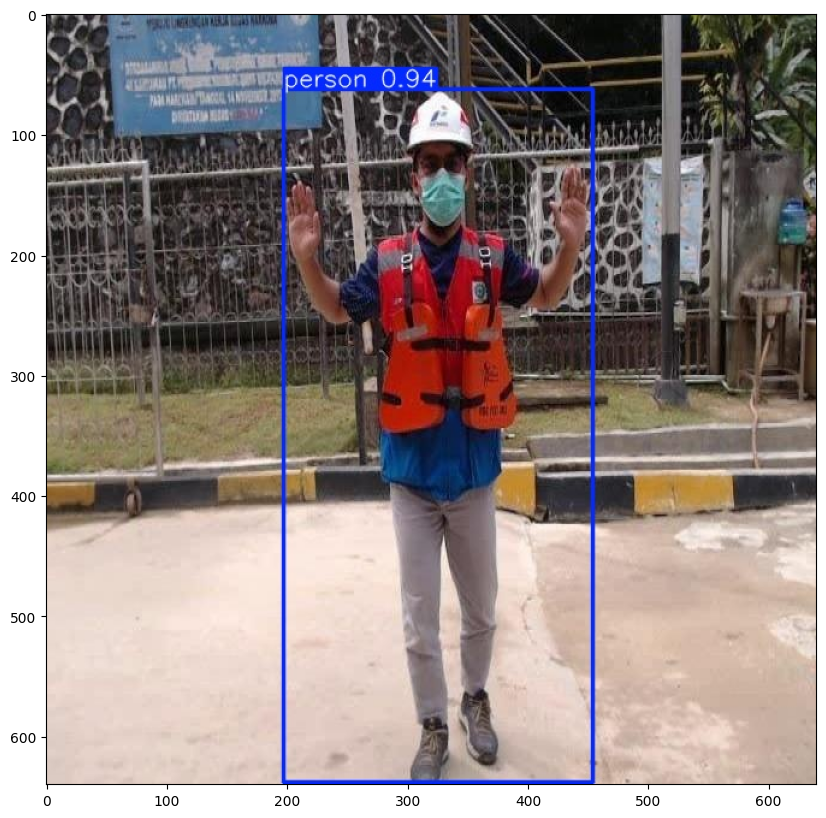

In [ ]:
example_image_inference_output = example_file_path.split('/')[-1]
display_image(f'/content/runs/detect/predict/{example_image_inference_output}')

In [ ]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  50
Batch:  16


### Assigning yaml and creating fine tuned YOLO model

In [ ]:
yaml_path = create_yaml_file()

In [ ]:
def train_model(yaml_path):
    model = YOLO(CFG.BASE_MODEL_WEIGHTS)

    img_properties = {'width': 640, 'height': 640}

    # Use 'cuda' or 'cuda:0' if you have a single GPU
    device_str = CFG.DEVICE if CFG.DEVICE == 'cpu' else 'cuda:0'

    model.train(
        data=yaml_path,
        task='detect',
        imgsz=(img_properties['height'], img_properties['width']),
        epochs=CFG.EPOCHS,
        batch=CFG.BATCH_SIZE,
        optimizer=CFG.OPTIMIZER,
        lr0=CFG.LR,
        lrf=CFG.LR_FACTOR,
        weight_decay=CFG.WEIGHT_DECAY,
        dropout=CFG.DROPOUT,
        fraction=CFG.FRACTION,
        patience=CFG.PATIENCE,
        profile=CFG.PROFILE,
        label_smoothing=CFG.LABEL_SMOOTHING,
        name=f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
        seed=CFG.SEED,
        val=True,
        amp=True,
        exist_ok=True,
        resume=False,
        device=device_str,  # Changed to use single GPU or CPU
        verbose=False,
    )

    return model

In [ ]:
model = train_model(yaml_path)

100%|██████████| 112M/112M [00:03<00:00, 33.2MB/s]


Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/content/drive/MyDrive/Capstone/model/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=yolov9e_ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

100%|██████████| 755k/755k [00:00<00:00, 99.4MB/s]


WARNING ⚠️ YOLOv9 `Silence` module is deprecated in favor of nn.Identity. Please delete local *.pt file and re-download the latest model checkpoint.
Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6          

100%|██████████| 6.25M/6.25M [00:00<00:00, 290MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /content/drive/MyDrive/Capstone/data/labels/train.cache... 3397 images, 6 backgrounds, 0 corrupt: 100%|██████████| 3397/3397 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Capstone/data/images/train/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Capstone/data/images/train/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Capstone/data/labels/valid.cache... 176 images, 10 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      21.6G      1.236      1.728      1.473         57        640: 100%|██████████| 213/213 [04:26<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        176        918      0.437      0.455      0.353      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      21.4G      1.257      1.545      1.489         57        640: 100%|██████████| 213/213 [01:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


                   all        176        918      0.624      0.436      0.471      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      21.7G      1.236      1.523      1.481         71        640: 100%|██████████| 213/213 [01:27<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


                   all        176        918      0.654      0.453      0.478      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      21.6G      1.183      1.427      1.433         57        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


                   all        176        918      0.662      0.529      0.526      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      21.3G      1.146      1.317      1.411        150        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]


                   all        176        918      0.721      0.503      0.575      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      21.4G      1.113      1.235      1.383         96        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


                   all        176        918      0.762      0.578      0.616      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      20.4G      1.083      1.155      1.351         78        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


                   all        176        918      0.754      0.579      0.638      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      21.4G       1.05      1.096      1.332         61        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


                   all        176        918      0.849      0.584      0.671      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      21.3G      1.026      1.057      1.314         78        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


                   all        176        918      0.783      0.611      0.671      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      21.4G      1.007     0.9864      1.294        111        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


                   all        176        918      0.806       0.63      0.694      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      20.4G     0.9758       0.95      1.279         82        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all        176        918       0.85      0.639       0.72      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      21.4G      0.962     0.9117      1.266         42        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

                   all        176        918      0.873      0.624      0.716      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      21.3G     0.9423      0.885      1.247         98        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        176        918      0.836      0.662      0.744      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      21.4G     0.9089     0.8492      1.231         73        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all        176        918       0.87      0.664      0.746      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      21.7G     0.9053      0.821      1.226        110        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

                   all        176        918      0.847      0.682      0.743      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      20.3G     0.8881     0.7995      1.216        127        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all        176        918      0.877      0.677      0.748      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      21.3G     0.8773      0.773      1.199        158        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all        176        918      0.836      0.688      0.752      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      21.4G     0.8631      0.744      1.191        178        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        176        918      0.852      0.656       0.75      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      21.4G     0.8427     0.7287      1.176         53        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        176        918      0.881      0.668      0.759      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      21.4G     0.8277     0.7063      1.171         79        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all        176        918      0.884      0.701      0.786      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      21.3G     0.8205     0.6915      1.165        101        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

                   all        176        918      0.887      0.713      0.797      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      21.4G     0.8054     0.6738      1.155         91        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        176        918      0.869      0.708       0.79       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      21.7G     0.7919       0.66      1.144         68        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

                   all        176        918      0.884      0.719      0.796       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      21.4G     0.7794      0.635      1.134        100        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        176        918      0.892      0.733      0.801      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      21.3G     0.7697     0.6297      1.131        129        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        176        918      0.888      0.721      0.796      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      21.4G     0.7605     0.6088      1.118         68        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        176        918      0.856       0.75      0.812      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      20.4G     0.7458     0.5994      1.117        170        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all        176        918      0.896      0.733       0.82      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      20.4G     0.7327     0.5881      1.105         95        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        176        918      0.901      0.751      0.831      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      21.3G      0.729     0.5699      1.091        165        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        176        918      0.918      0.741      0.827      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      21.4G     0.7184     0.5609      1.091         90        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        176        918      0.937      0.744      0.821      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      21.7G     0.7083     0.5517      1.089         76        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        176        918      0.918       0.74      0.823      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      21.4G     0.6951     0.5348       1.08        113        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        176        918      0.926       0.74      0.829      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      21.3G     0.6846     0.5196      1.068        101        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        176        918      0.891      0.772      0.834      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      21.4G      0.679     0.5216       1.07         48        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all        176        918      0.902      0.768      0.833      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      20.4G     0.6601     0.4986      1.056         79        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        176        918      0.924       0.73      0.829      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      21.6G     0.6513     0.4965      1.049         53        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        176        918      0.897      0.787      0.849      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      21.3G     0.6394     0.4801      1.046         95        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        176        918      0.881      0.799      0.852      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      21.4G     0.6353     0.4766      1.043        103        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        176        918      0.926      0.779      0.856      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      21.4G     0.6221     0.4641      1.041         95        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

                   all        176        918      0.937      0.784      0.862      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      20.4G     0.6064     0.4546       1.03        137        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        176        918      0.921      0.745      0.855       0.58


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      21.3G     0.6144     0.3935      1.021         52        640: 100%|██████████| 213/213 [01:31<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        176        918       0.92      0.791      0.854      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      21.4G     0.5977     0.3828      1.011        103        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

                   all        176        918      0.924      0.794       0.86       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      21.4G     0.5784     0.3627      1.004         17        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        176        918      0.922      0.784      0.856      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      20.1G     0.5704     0.3581     0.9978         68        640: 100%|██████████| 213/213 [01:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all        176        918      0.904      0.807      0.866      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      21.3G     0.5609     0.3509     0.9873         64        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        176        918      0.947      0.783      0.872      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      21.4G     0.5371     0.3333     0.9734         40        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

                   all        176        918      0.952      0.799      0.875      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      21.4G     0.5328     0.3314     0.9746         79        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        176        918      0.919      0.814      0.878      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      21.4G     0.5248      0.327     0.9751         40        640: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all        176        918       0.92      0.831      0.886      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      21.3G     0.5119      0.317     0.9644         66        640: 100%|██████████| 213/213 [01:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        176        918      0.913      0.829      0.884      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      21.4G     0.5004     0.3102     0.9553         41        640: 100%|██████████| 213/213 [01:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        176        918      0.911      0.827      0.882      0.632



50 epochs completed in 1.322 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_50_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt...
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


                   all        176        918      0.913      0.829      0.884      0.637
Speed: 0.1ms preprocess, 21.3ms inference, 0.1ms loss, 7.1ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_50_epochs


In [ ]:
image_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

### Exporting model for deployment and testing

In [ ]:
def export_model(model):
    # Export the model for deployment
    model.export(
        format='onnx',  # Could be 'openvino', 'engine', 'tflite', etc.
        imgsz=(640, 640),
        half=False,
        int8=False,
        simplify=False,
        nms=False,
    )

In [ ]:
export_model(model)

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.8 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 222.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.0s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 13.5s, saved as 'runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx' (219.3 MB)

Export complete (17.9s)
Results saved to /content/runs/detect/yolov9e_ppe_css_50_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_50_e

### Checking Model Evaluation

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'/content/runs/detect/yolov9e_ppe_css_50_epochs/*.png') +
    glob.glob(f'/content/runs/detect/yolov9e_ppe_css_50_epochs/*.jpg')
    if 'batch' not in i
]

results_paths

['/content/runs/detect/yolov9e_ppe_css_50_epochs/R_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_50_epochs/P_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_50_epochs/PR_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix_normalized.png',
 '/content/runs/detect/yolov9e_ppe_css_50_epochs/F1_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_50_epochs/results.png',
 '/content/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix.png',
 '/content/runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg',
 '/content/runs/detect/yolov9e_ppe_css_50_epochs/labels_correlogram.jpg']

### Please refer to my report for evaluation of the important results

/content/runs/detect/yolov9e_ppe_css_50_epochs/F1_curve.png


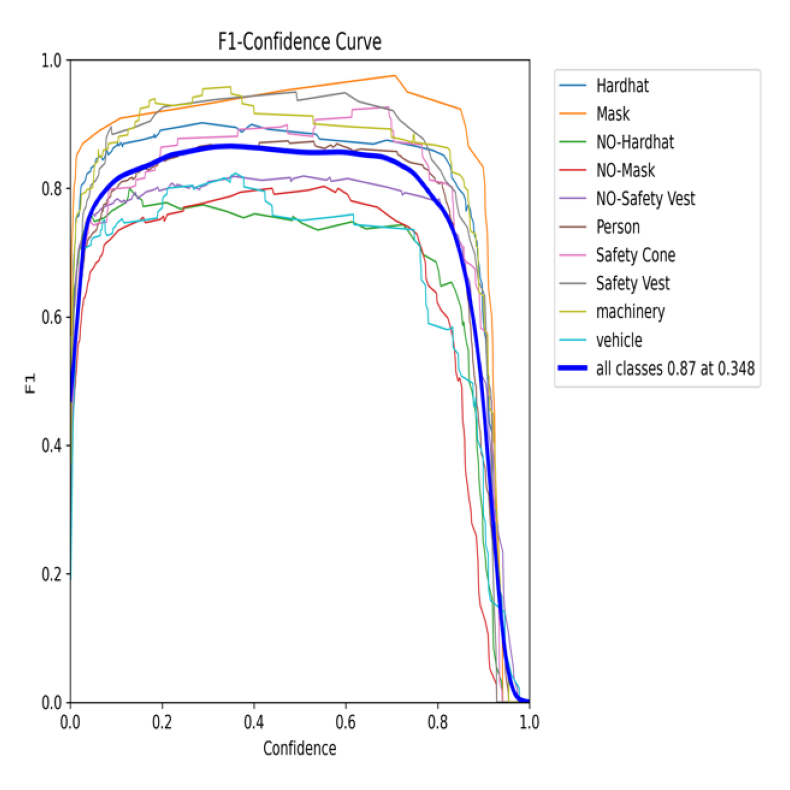



/content/runs/detect/yolov9e_ppe_css_50_epochs/PR_curve.png


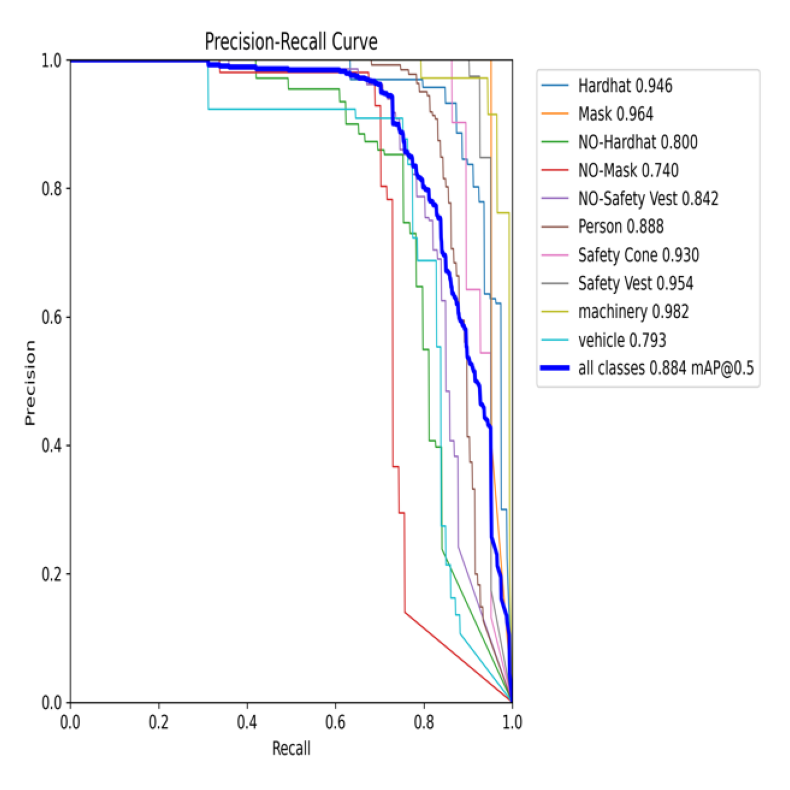



/content/runs/detect/yolov9e_ppe_css_50_epochs/P_curve.png


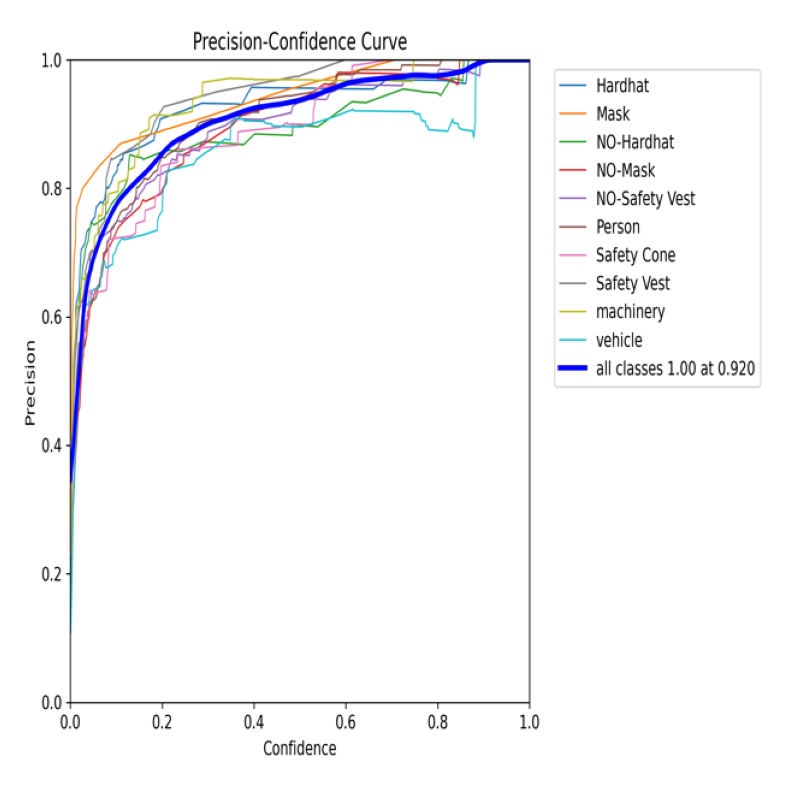



/content/runs/detect/yolov9e_ppe_css_50_epochs/R_curve.png


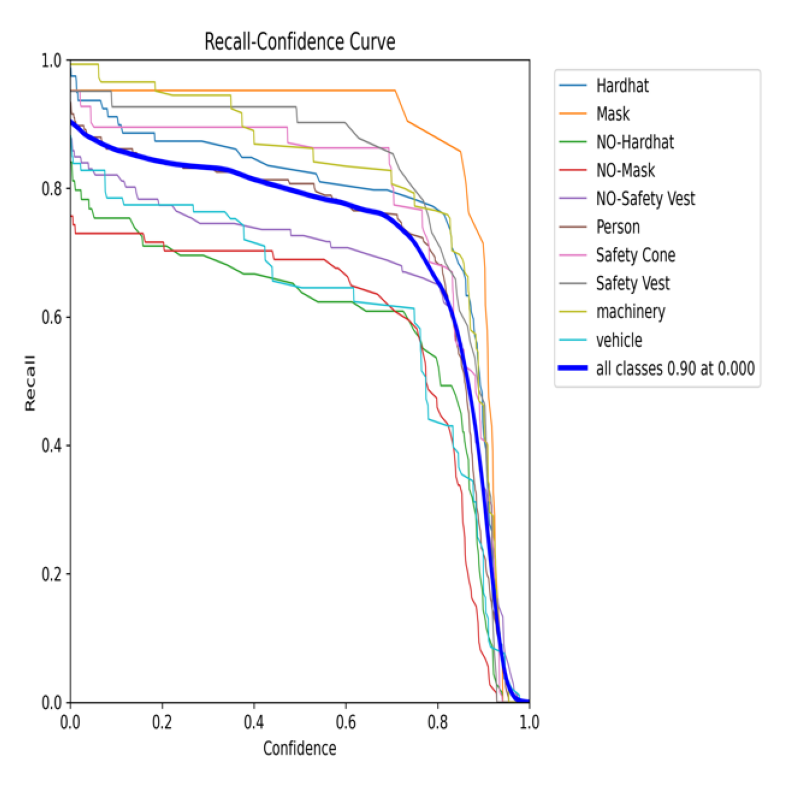



/content/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix.png


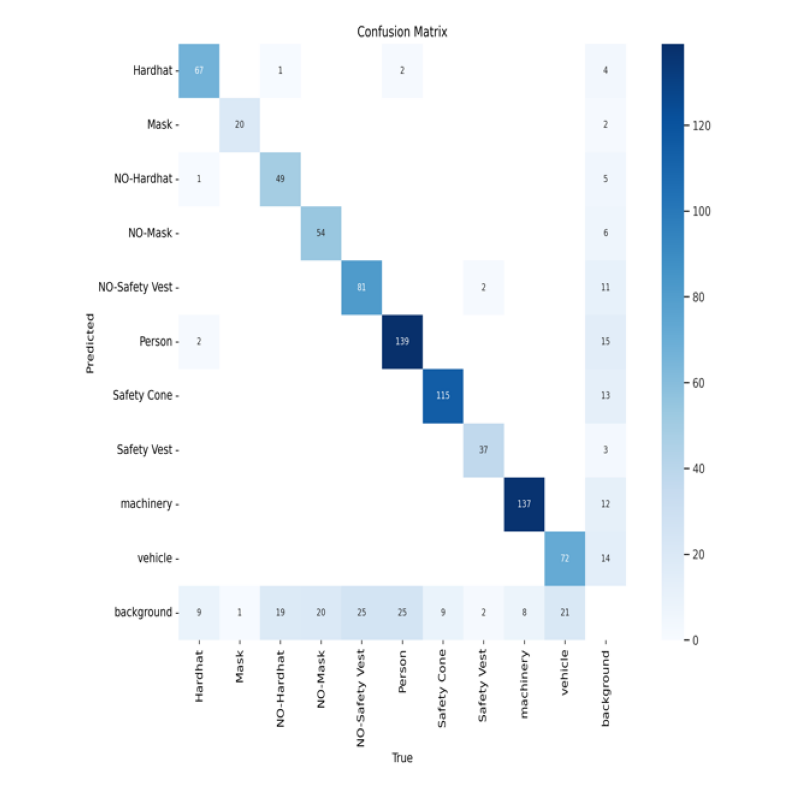



/content/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix_normalized.png


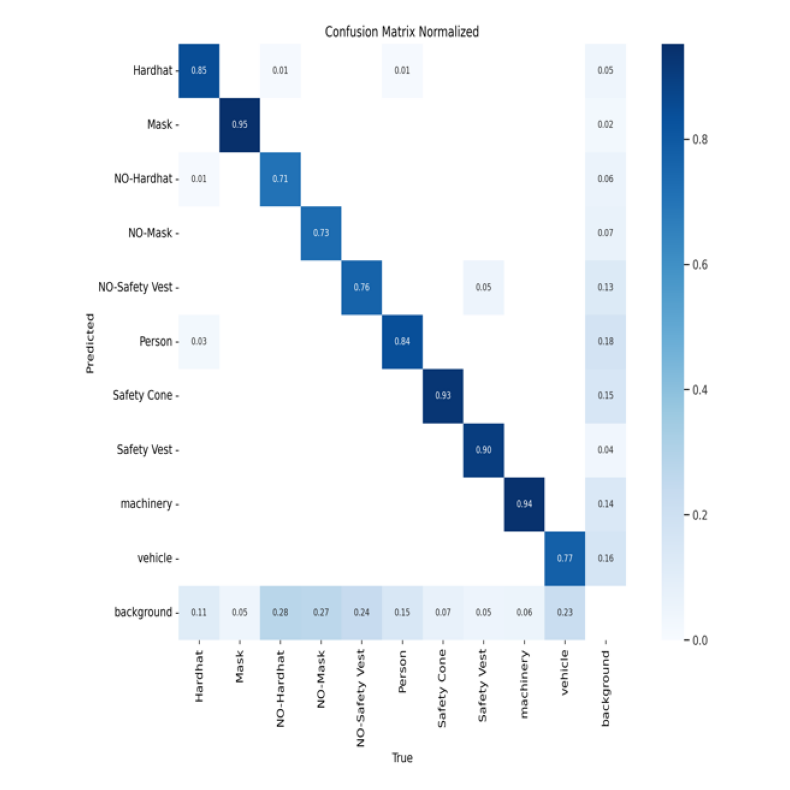



/content/runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg


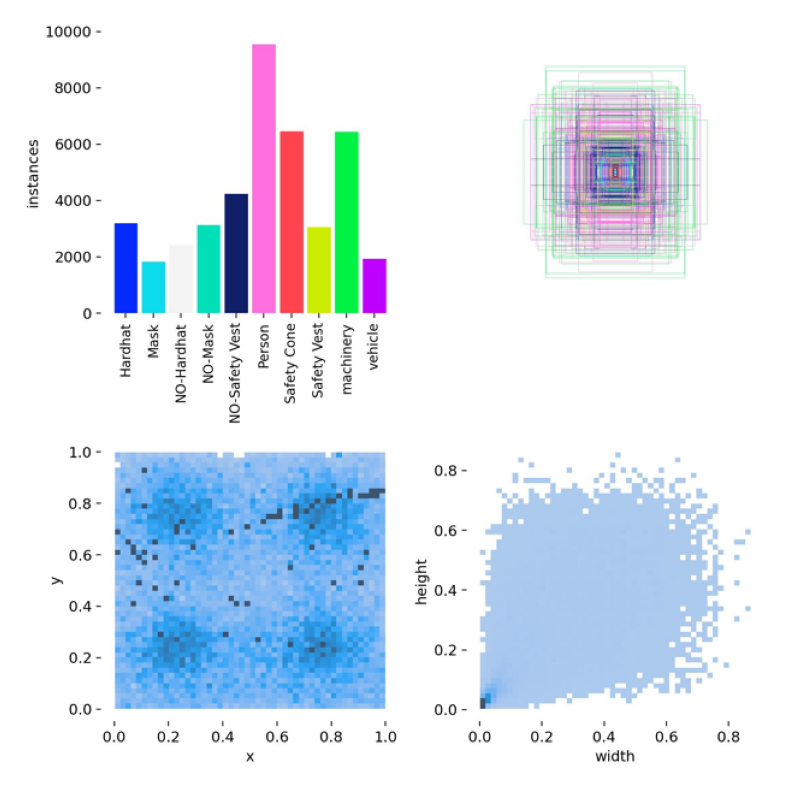



/content/runs/detect/yolov9e_ppe_css_50_epochs/labels_correlogram.jpg


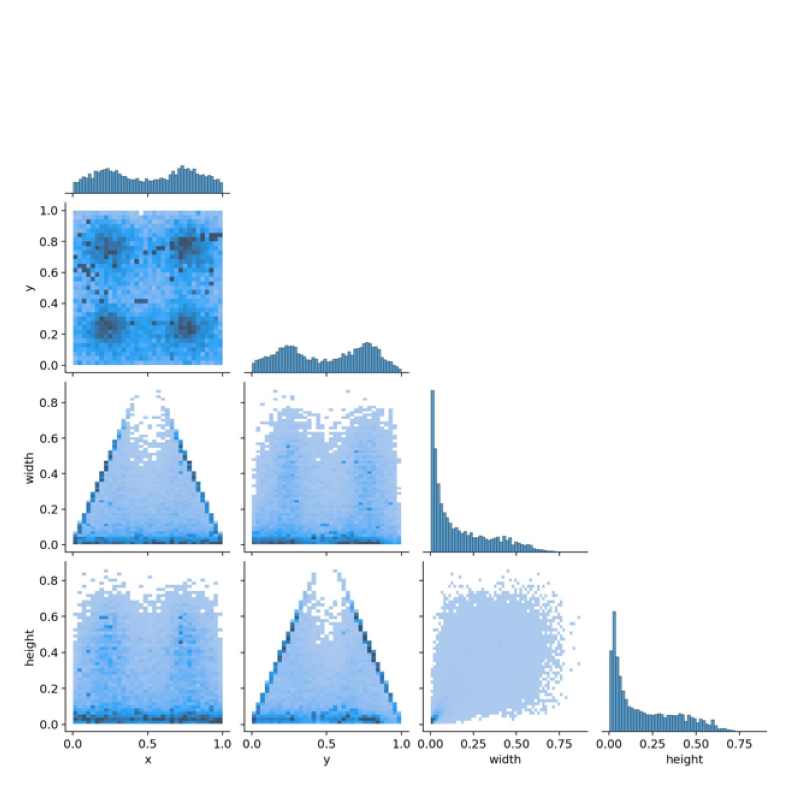



/content/runs/detect/yolov9e_ppe_css_50_epochs/results.png


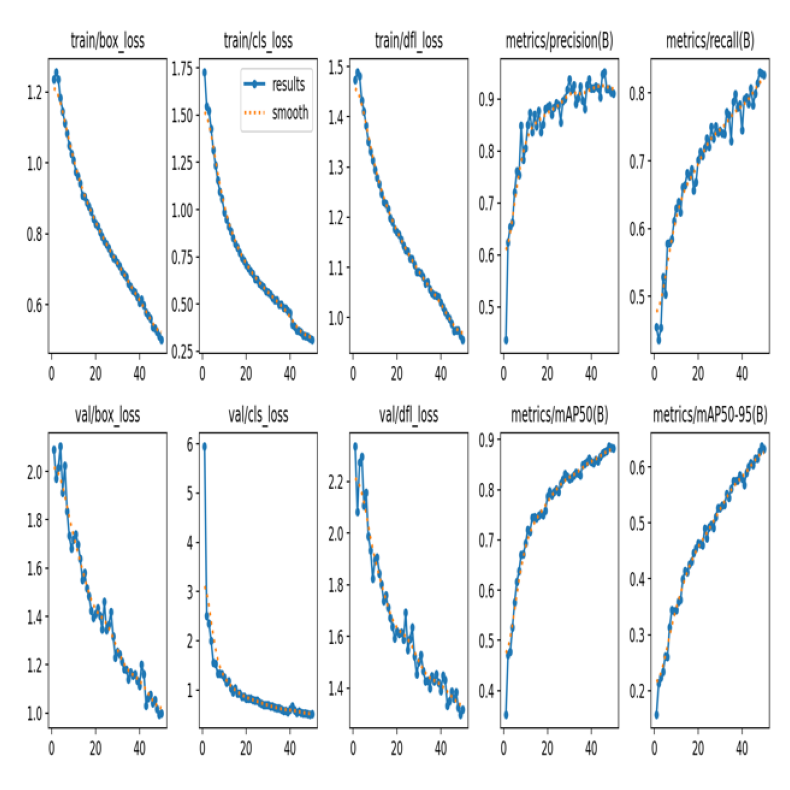

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info=False, hide_axis=True)
    print('\n')

### Saving numeriacal results to access as csv

In [ ]:
results = pd.read_csv('/content/runs/detect/yolov9e_ppe_css_50_epochs/results.csv')
results.to_csv(f'{OUTPUT_DIR}/results.csv', index=False)

### Plotting training metrics from CSV

In [ ]:
# Function to plot training metrics from CSV
def plot_training_metrics(df):
    metrics = ['box_loss', 'cls_loss', 'dfl_loss']
    titles = ['Box Loss', 'Cls Loss', 'DFL Loss']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(3, 1, i + 1)
        plt.plot(df['epoch'], df[f'train/{metric}'], label=f'Training {metric}')
        plt.plot(df['epoch'], df[f'val/{metric}'], label=f'Validation {metric}')
        plt.title(titles[i])
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def print_best_performance(df):
    print('*' * 50)
    print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].idxmin() + 1, '\n')
    print('Best Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].idxmin() + 1, '\n')

    print('=' * 50)
    print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].idxmin() + 1, '\n')
    print('Best Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].idxmin() + 1, '\n')

    print('=' * 50)
    print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].idxmin() + 1, '\n')
    print('Best Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].idxmin() + 1, '\n')

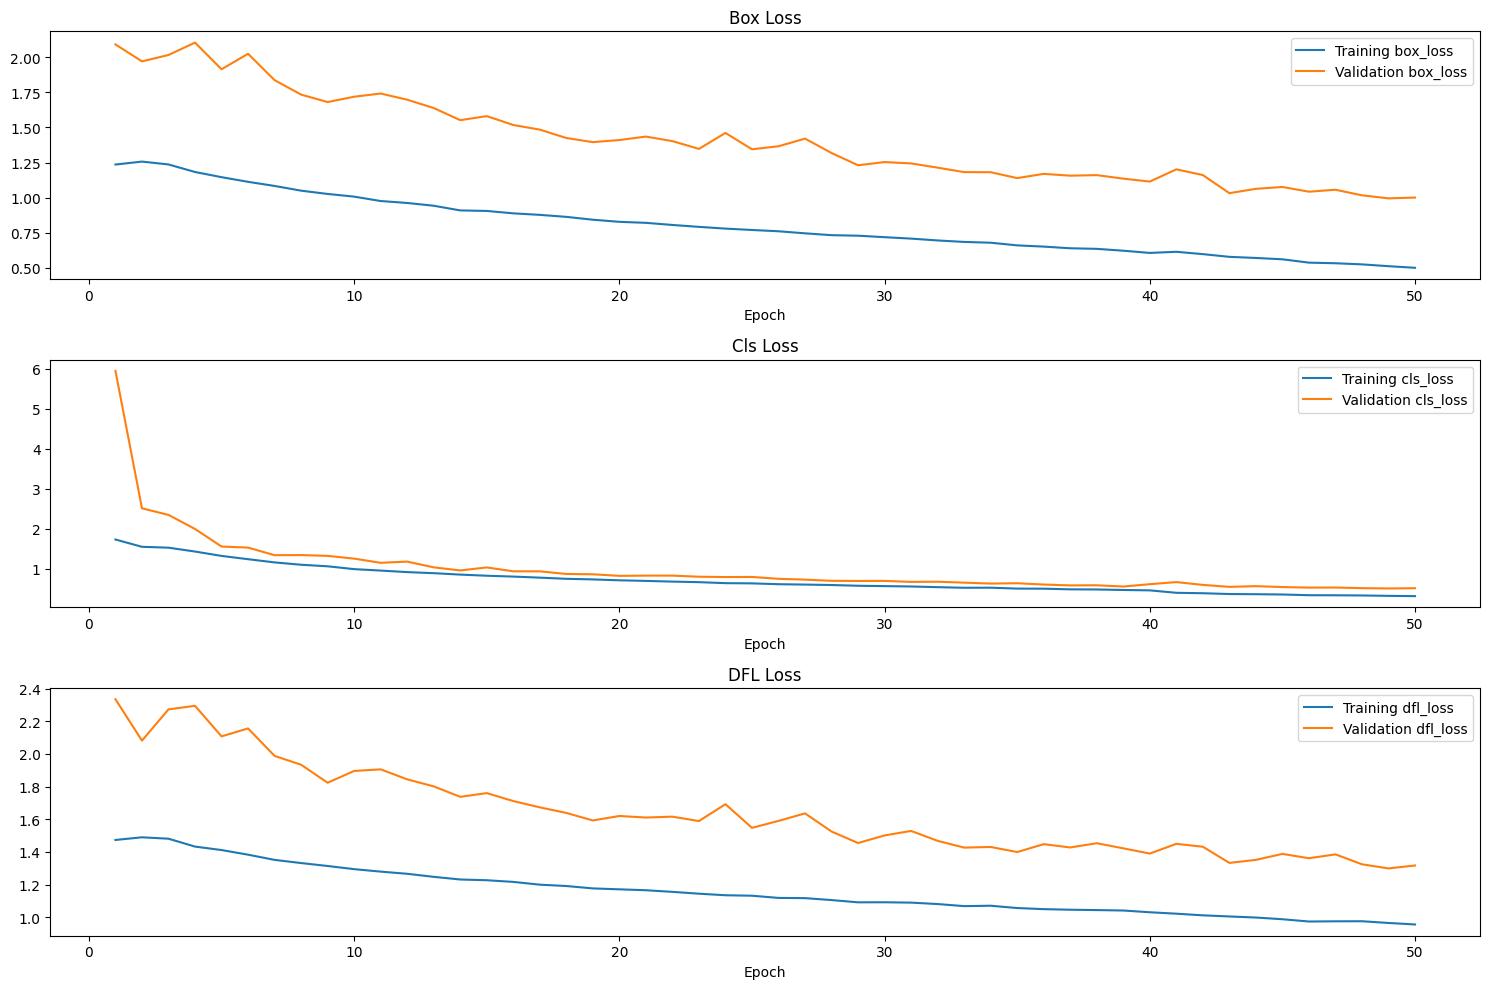

**************************************************

Best Training Box loss:  0.50045 , on epoch:  50 

Best Validation Box loss:  0.99476 , on epoch:  49 


Best Training Cls loss:  0.31019 , on epoch:  50 

Best Validation Cls loss:  0.50228 , on epoch:  49 


Best Training DFL loss:  0.95526 , on epoch:  50 

Best Validation DFL loss:  1.2987 , on epoch:  49 



In [ ]:
df = pd.read_csv(r'/content/runs/detect/yolov9e_ppe_css_50_epochs/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{OUTPUT_DIR}/training_log_df.csv', index=False)
plot_training_metrics(df)
print_best_performance(df)

### Testing model on all testing images

In [ ]:
model = YOLO(f'{drive_base_path}/yolov9e_ppe_css_50_epochs_w_loss/yolov9e_ppe_css_50_epochs_w_loss/weights/best.pt')
def perform_inference_and_visualize_all(model):
    model = YOLO(f'{drive_base_path}/yolov9e_ppe_css_50_epochs_w_loss/yolov9e_ppe_css_50_epochs_w_loss/weights/best.pt')
    # List all image files in the test directory
    test_image_files = [f for f in os.listdir(TEST_IMAGE_PATH) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Iterate over each test image
    for image_file in test_image_files:
        test_image_path = os.path.join(TEST_IMAGE_PATH, image_file)

        # Perform inference on the test image
        results = model.predict(test_image_path, conf=0.25, device=CFG.DEVICE)

        # Display the result
        result_image = results[0].plot()
        plt.figure(figsize=(12, 12))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Test Image Prediction: {image_file}')
        plt.show()

In [ ]:
perform_inference_and_visualize_all(model)

### Saving the model to drive to download

In [ ]:
import shutil

# Source directory path in Colab
source_dir = '/content/runs/detect'  # Replace with your actual directory path

# Destination directory in Google Drive
destination_dir = '/content/drive/MyDrive/Capstone/yolov9e_ppe_css_51_epochs_w_loss'  # Replace with the desired path in Google Drive

# Copy the directory to Google Drive
shutil.copytree(source_dir, destination_dir)
print("Directory saved to Google Drive.")

Directory saved to Google Drive.


### Applying the model to test on video using 'Bytetrack'

In [ ]:
import os
from google.colab import drive
from IPython.display import HTML
from base64 import b64encode
from ultralytics import YOLO

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_base_path = '/content/drive/MyDrive/Capstone'
weights_dir = os.path.join(drive_base_path, 'yolov9e_ppe_css_50_epochs_w_loss', 'yolov9e_ppe_css_50_epochs', 'weights')
video_path = os.path.join(drive_base_path, 'construction workers.mp4')  # Update this path to the actual video location
save_dir = os.path.join(drive_base_path, 'tracking_results_50_epochs')

# Load the trained detection model
model = YOLO(os.path.join(weights_dir, 'best.pt'))

# Run tracking
tracking_results = model.track(
    source=video_path,
    show=True,
    save=True,
    name=save_dir,
    imgsz=640,
    tracker="bytetrack.yaml"  # Using ByteTrack
)

Convert output video from .avi to .mp4
!ffmpeg -i /content/drive/MyDrive/Capstone/tracking_results_50_epochs/construction workers.avi /content/drive/MyDrive/Capstone/tracking_results_50_epochs/construction_workersg.mp4
# !ffmpeg -i /content/drive/MyDrive/Capstone/tracking_results2/JapanPPE.avi /content/drive/MyDrive/Capstone/tracking_results2/JapanPPEc.mp4



In [ ]:
def play_video(filename):
    video_data = open(filename, 'rb').read()
    video_src = 'data:video/mp4;base64,' + b64encode(video_data).decode()

    html = f'<video width=1000 controls autoplay loop><source src="{video_src}" type="video/mp4"></video>'
    return HTML(html)

# Display the converted video
play_video('/content/drive/MyDrive/Capstone/tracking_results/construction_workersg.mp4')
